# Punto 1: Creación de Variables Dicotómicas

**Enunciado:**  
Se debe crear una variable dicotómica para cada una de las categorías de la variable respuesta categórica que se definió en hojas anteriores. Es decir, se deben generar tres nuevas variables (con valores 0 y 1) que indiquen si una vivienda es:
- **Cara o no:** Una variable que tome el valor 1 si la vivienda se clasifica como "cara" y 0 en caso contrario.
- **Media o no:** Una variable que indique si la vivienda se encuentra en la categoría "media" (por ejemplo, en el tercil intermedio) y 0 si no lo es.
- **Económica o no:** Una variable que tome el valor 1 si la vivienda es "económica" (por ejemplo, en el tercil inferior) y 0 en caso contrario.




In [ ]:
from pathlib import Path
import pandas as pd, numpy as np, joblib

# cargar datos
df = pd.read_csv('train.csv')              # <-- ruta al archivo base

# calcular terciles y categorías
q1, q2 = df['SalePrice'].quantile([.33, .66])

def categoria(p):
    if p <= q1:       return 'barata'
    elif p <= q2:     return 'media'
    else:             return 'cara'

df['cat_price'] = df['SalePrice'].apply(categoria)
df['is_barata'] = (df['cat_price'] == 'barata').astype(int)
df['is_media']  = (df['cat_price'] == 'media' ).astype(int)
df['is_cara']   = (df['cat_price'] == 'cara'  ).astype(int)

Path("data").mkdir(parents=True, exist_ok=True)

# guardar dataset y puntos de corte
df.to_csv('data/train_cat.csv', index=False)
joblib.dump({'q1': q1, 'q2': q2}, 'data/cut_points.joblib')

print("✔ Dummies creadas y archivo guardado.")
print(df[['SalePrice','cat_price','is_barata','is_media','is_cara']].head())


✔ Dummies creadas y archivo guardado.
   SalePrice cat_price  is_barata  is_media  is_cara
0     208500      cara          0         0        1
1     181500     media          0         1        0
2     223500      cara          0         0        1
3     140000     media          0         1        0
4     250000      cara          0         0        1


El criterio de clasificación puede basarse en los terciles o percentiles del valor de la vivienda (por ejemplo, la variable `SalePrice`).

**Interpretación de Resultados:**  
- **Variable `is_cara`:** Indica que una vivienda se considera cara cuando su precio se encuentra en el tercil superior. Un valor de 1 implica que la propiedad tiene un precio alto, mientras que 0 indica lo contrario.
- **Variable `is_media`:** Indica que una vivienda está en una categoría de precio intermedia (típicamente, el tercil medio). Un 1 en esta variable significa que la propiedad no es ni cara ni económica, sino que se ubica en un rango intermedio.
- **Variable `is_economica` (o `is_barata`):** Señala que una vivienda es económica cuando su precio está en el tercil inferior. Un valor de 1 significa que la propiedad se clasifica como de bajo costo, lo que puede estar vinculado a características específicas o a ubicaciones menos privilegiadas.

El uso de estas variables dicotómicas facilita la aplicación de modelos de clasificación en entregas posteriores, permitiendo analizar y comparar el desempeño de distintos algoritmos (por ejemplo, Regresión Logística, Árboles de Decisión, Random Forest, etc.) con base en categorías bien definidas del precio de la vivienda. Además, estas variables ayudan a identificar qué características influyen en el precio y a plantear estrategias específicas en el sector inmobiliario.

# Punto 2: Uso de los mismos conjuntos de entrenamiento y prueba

**Enunciado:**  
Se deben utilizar los mismos conjuntos de entrenamiento y prueba (train/test) que se definieron en las hojas anteriores. Esto permite asegurar la reproducibilidad de los experimentos y la coherencia en las comparaciones de rendimiento entre distintos modelos y pasos del proyecto.


In [6]:
import pandas as pd, joblib
from sklearn.model_selection import train_test_split
SEED = 221087
df = pd.read_csv('data/train_cat.csv')

y = df['is_cara']                                   # objetivo dicotómico
X = df.drop(columns=['SalePrice','cat_price',
                     'is_barata','is_media','is_cara'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y)

joblib.dump((X_train,X_test,y_train,y_test),'data/splits.joblib')
print("Splits guardados – reproducibles.")


Splits guardados – reproducibles.


**Interpretación de Resultados:**  
- **Consistencia de la Evaluación:** Al emplear exactamente los mismos datos de entrenamiento y de prueba en cada modelo, se logra comparar de forma justa (fair comparison) los distintos enfoques de clasificación.  
- **Reproducibilidad:** Fijar una semilla (por ejemplo, `SEED = 221087`) y utilizar la misma partición asegura que, cada vez que se ejecuta el script, se obtenga el mismo `X_train`, `X_test`, `y_train`, `y_test`. Esto facilita depurar errores, compartir resultados y garantizar que el comportamiento de los modelos no varíe por cambios accidentales en los datos.  
- **Enfoque Científico:** Mantener los mismos conjuntos de entrenamiento y prueba es clave para la validez de los experimentos de minería de datos y aprendizaje automático, ya que se aísla la evaluación de los modelos de factores externos y se reduce el riesgo de sobreajuste o de sesgos en la división de los datos.  

En esta etapa, simplemente confirmamos y documentamos el uso de la misma partición que se estableció en las hojas anteriores para todos los modelos subsecuentes.

# Punto 3: Modelo de Regresión Logística para determinar si una vivienda es cara o no

**Enunciado:**  
Se debe elaborar un modelo de Regresión Logística para predecir si una vivienda es "cara" (es decir, si `is_cara == 1`). El entrenamiento debe realizarse únicamente con el conjunto de entrenamiento establecido y debe incluir:
1. Un pipeline de preprocesamiento (por ejemplo, imputación de datos faltantes y/o escalado).
2. Una etapa de validación cruzada para estimar la capacidad de generalización del modelo.
3. La fijación de la semilla y la partición de los datos para garantizar que el experimento sea reproducible.



In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import joblib

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score

SEED = 221087

X_train, X_test, y_train, y_test = joblib.load('data/splits.joblib')

# columnas numéricas y categóricas
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(exclude=['int64', 'float64']).columns

# Pipelines de pre‑proceso
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore'))
])

prepro = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])

# Modelo de Regresión Logística
logit = LogisticRegression(max_iter=1000, random_state=SEED)

pipe = Pipeline([
    ('prep', prepro),
    ('clf',  logit)
])

# Validación cruzada estratificada (5‑fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='accuracy')

print(f"Exactitud CV por fold: {np.round(scores, 3)} | Media: {scores.mean():.3f}")
pipe.fit(X_train, y_train)

# Guardar el modelo entrenado
Path('models').mkdir(parents=True, exist_ok=True)
joblib.dump(pipe, 'models/logit_cara.joblib')
print("✔ Modelo guardado en models/logit_cara.joblib")


Exactitud CV por fold: [0.923 0.902 0.932 0.931 0.91 ] | Media: 0.920
✔ Modelo guardado en models/logit_cara.joblib


Una vez entrenado el modelo, se debe explicar brevemente los resultados a los que se llega (por ejemplo, el valor de la métrica de validación cruzada). El objetivo es que, cada vez que se ejecute el código, se utilicen los mismos conjuntos de entrenamiento y prueba, y se obtengan resultados consistentes.

**Interpretación de Resultados:**  
- **Entrenamiento y Pipeline:** El modelo de Regresión Logística aprende, a partir de las variables predictoras (features), la probabilidad de que una vivienda sea cara (clase positiva). Mediante la combinación de imputación y escalado, se normalizan los datos para estabilizar los coeficientes y facilitar la convergencia del algoritmo.
- **Validación Cruzada:** Al usar una técnica como k‑fold (por ejemplo, con 5 pliegues), se obtiene una mejor aproximación de la capacidad de generalización del modelo, reduciendo la dependencia de una sola partición. Se presentan métricas como el accuracy promedio y la desviación estándar entre pliegues.
- **Reproducibilidad:** Fijar la semilla y emplear los mismos splits de entrenamiento y prueba permite que cualquier persona que ejecute el código obtenga los mismos resultados, lo cual es esencial para la robustez de la investigación.
- **Rendimiento y Métricas:** Si, por ejemplo, la validación cruzada arroja una exactitud promedio de 0.85 con una desviación de 0.02, esto significa que el modelo acierta en un 85 % de los casos, en promedio, al determinar si una vivienda es cara o no. Esta métrica puede complementarse con ROC AUC, precisión (precision), exhaustividad (recall) y otras para profundizar en la evaluación.
- **Almacenamiento del Modelo:** Guardar el modelo (por ejemplo, en un archivo `.joblib`) tras entrenarlo facilita su uso posterior para la etapa de predicción o para su integración con otros sistemas, sin tener que reentrenarlo cada vez.

Con esto se logra un modelo capaz de distinguir entre viviendas caras y no caras, fundamentado en un proceso reproducible y validado, lo cual proporciona la base para escalas mayores o proyectos posteriores en el área de minería de datos y aprendizaje automático.

# Punto 4: Análisis del Modelo y Detección de Multicolinealidad

**Enunciado:**  
1. Analizar el modelo entrenado previamente para determinar:
   - Si existe multicolinealidad en las variables.
   - Cuáles variables aportan significativamente al modelo (con base en su p‑value, VIF, etc.).
   - La correlación existente entre las variables usadas en el modelo.
2. Especificar si el modelo se adapta bien a los datos, basándose en medidas como el R‑cuadrado pseudo, log‑likelihood o en el comportamiento de los coeficientes.


In [ ]:
from pathlib import Path
import joblib, pandas as pd, numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import SimpleImputer

# Función auxiliar para eliminar columnas que causen colinealidad
def get_full_rank_columns(X):
    cols = list(X.columns)
    while np.linalg.matrix_rank(X[cols].values) < len(cols):
        # Calcular VIF para cada columna
        vif_series = pd.Series(
            [variance_inflation_factor(X[cols].values, i) for i in range(len(cols))],
            index=cols
        )
        # Se elimina la columna con el VIF más alto
        drop_col = vif_series.idxmax()
        print(f"Dropping column '{drop_col}' (VIF: {vif_series[drop_col]:.2f}) due to singularity.")
        cols.remove(drop_col)
    return cols

X_train, X_test, y_train, y_test = joblib.load('data/splits.joblib')
X_dum = pd.get_dummies(X_train, drop_first=True)
X_dum = X_dum.loc[:, (X_dum != X_dum.iloc[0]).any()]  # eliminar columnas sin variación

# Imputar valores faltantes
imp = SimpleImputer(strategy='most_frequent')
X_dum_imp = pd.DataFrame(
    imp.fit_transform(X_dum),
    columns=X_dum.columns,
    index=X_dum.index
).astype(float)

X_const = sm.add_constant(X_dum_imp, prepend=True)
initial_rank = np.linalg.matrix_rank(X_const.values)
print(f"Rango inicial de la matriz (incl. constante): {initial_rank} de {X_const.shape[1]} columnas")

# Eliminar columnas colineales hasta lograr rango completo
full_rank_cols = get_full_rank_columns(X_const)
X_const_full = X_const[full_rank_cols]
final_rank = np.linalg.matrix_rank(X_const_full.values)
print(f"Rango final de la matriz: {final_rank} de {X_const_full.shape[1]} columnas")

# Ajustar el modelo Logit
try:
    logit_sm = sm.Logit(y_train.astype(float), X_const_full).fit(disp=False, method='lbfgs')
    print("Ajuste exitoso usando método 'lbfgs'.")
except Exception as e:
    print("Error en ajuste con 'lbfgs':", e)
    print("Usando ajuste regularizado...")
    logit_sm = sm.Logit(y_train.astype(float), X_const_full).fit_regularized(maxiter=1000, disp=False)
    print("Ajuste regularizado completado.")

# Guardar el resumen (coeficientes y, si disponible, p‑values) en CSV
Path('tables').mkdir(parents=True, exist_ok=True)
try:
    summary_table = logit_sm.summary2().tables[1]
except Exception:
    # Si se usó regularización, puede que summary2 no incluya p‑values.
    summary_table = pd.DataFrame({'coef': logit_sm.params})
summary_table.to_csv('tables/logit_coeffs_pvalues.csv')
print("✔ Resultados guardados en 'tables/logit_coeffs_pvalues.csv'")

# Calcular VIF para las variables del modelo
vif_df = pd.DataFrame({
    'feature': X_const_full.columns,
    'VIF': [variance_inflation_factor(X_const_full.values, i)
            for i in range(X_const_full.shape[1])]
})
vif_df.to_csv('tables/vif_logit.csv', index=False)
print("✔ VIF guardado en 'tables/vif_logit.csv'")

num_cols = X_train.select_dtypes(include=['int64','float64']).columns
corr = X_train[num_cols].corr()
corr.to_csv('tables/corr_numeric.csv')
print("✔ Matriz de correlación guardada en 'tables/corr_numeric.csv'")

# Mostrar resultados clave en consola
print("\nTop‑10 variables más significativas (ordenadas por p‑value ascendente):")
try:
    print(summary_table.sort_values('P>|z|').head(10)[['Coef.', 'P>|z|']])
except Exception:
    print(summary_table.sort_values('coef').head(10))

print("\nTop‑10 VIF más altos:")
print(vif_df.sort_values('VIF', ascending=False).head(10))


Rango inicial de la matriz (incl. constante): 239 de 243 columnas


c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero e

Dropping column 'BsmtFinSF1' (VIF: inf) due to singularity.


c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero e

Dropping column '1stFlrSF' (VIF: inf) due to singularity.


c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropping column 'Exterior1st_CBlock' (VIF: inf) due to singularity.


c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropping column 'BsmtCond_Po' (VIF: inf) due to singularity.
Rango final de la matriz: 239 de 239 columnas


c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Ajuste exitoso usando método 'lbfgs'.
✔ Resultados guardados en 'tables/logit_coeffs_pvalues.csv'
✔ VIF guardado en 'tables/vif_logit.csv'
✔ Matriz de correlación guardada en 'tables/corr_numeric.csv'

Top‑10 variables más significativas (ordenadas por p‑value ascendente):
                   Coef.  P>|z|
const                0.0    1.0
ExterCond_TA         0.0    1.0
Foundation_CBlock    0.0    1.0
Foundation_PConc     0.0    1.0
Foundation_Slab      0.0    1.0
Foundation_Stone     0.0    1.0
Foundation_Wood      0.0    1.0
BsmtQual_Fa          0.0    1.0
BsmtQual_Gd          0.0    1.0
BsmtQual_TA          0.0    1.0

Top‑10 VIF más altos:
                 feature           VIF
0                  const  3.362789e+06
215        GarageCond_TA  2.136384e+02
211        GarageQual_TA  2.043732e+02
104      RoofStyle_Gable  1.367854e+02
106        RoofStyle_Hip  1.261288e+02
125  Exterior1st_VinylSd  1.173327e+02
140  Exterior2nd_VinylSd  1.043268e+02
121  Exterior1st_MetalSd  7.946753e+01


**Interpretación de Resultados:**  
- **Multicolinealidad:**  
  - Mediante la **varianza inflation factor (VIF)** o la inspección de correlaciones muy altas (por ejemplo, |ρ| > 0.8) se puede evidenciar si dos o más variables se solapan en la información que aportan al modelo. Un valor de VIF > 10 suele considerarse indicio de multicolinealidad seria.  
  - La multicolinealidad extrema puede causar inestabilidad en los coeficientes de la Regresión Logística, dificultando la interpretación y generando problemas de sobreajuste o de singularidad de la matriz.
- **Variables Significativas:**  
  - El **p‑value** asociado a cada coeficiente (en un ajuste sin regularización severa) indica qué tan relevante es la variable para predecir la categoría de la vivienda (cara o no, en este caso). Usualmente se toman como significativas las variables con p‑value < 0.05.  
  - Si el ajuste se hace con regularización, la interpretación tradicional de p‑values puede no estar disponible; en ese caso, se valoran los coeficientes que el modelo conserva (no penalizados a cero) como los más influyentes.
- **Correlación entre las Variables:**  
  - Examinar la **matriz de correlación** de las variables numéricas originales (o tras ciertas transformaciones) revela relaciones lineales fuertes. Por ejemplo, si `GarageArea` y `GarageCars` están fuertemente correlacionadas, puede sugerir que solo una de ellas es estrictamente necesaria.
  - Un análisis de correlación previo a la modelación permite reducir redundancias y mejorar la estabilidad del modelo.
- **Adaptación del Modelo a los Datos:**  
  - Para la Regresión Logística, suele analizarse el **Pseudo R‑squared (McFadden, Nagelkerke, etc.)** y el **Log‑likelihood** final. Valores más altos (o menos negativos, en el caso del log‑likelihood) sugieren un mejor ajuste.  
  - Sin embargo, un Pseudo R‑squared bajo no siempre implica un mal modelo: en clasificación, métricas como la exactitud, ROC AUC o la matriz de confusión pueden ser más relevantes para validar la calidad.
  - Si se observan avisos de “Singular matrix” o “divide by zero encountered”, es síntoma de multicolinealidad extrema o de separación casi perfecta en los datos, lo cual puede requerir eliminación de variables redundantes o uso de regularización.

**Conclusión General del Análisis:**  
- En este punto, se profundiza en la naturaleza del modelo: las variables más explicativas, la presencia de correlaciones redundantes y la robustez del ajuste.  
- Cualquier hallazgo de multicolinealidad severa o de variables con p‑values altos (p > 0.05) se documenta y se decide (o no) su exclusión en modelos posteriores.  
- Si el modelo presenta un comportamiento estable (sin grandes discrepancias, sin singularidades) y las métricas sugieren una buena discriminación entre viviendas caras y no caras, se concluye que el modelo se adapta adecuadamente a los datos. De lo contrario, se plantea un refinamiento adicional en pasos posteriores (por ejemplo, ajustando hiperparámetros, eliminando variables o aplicando técnicas de regularización).

# Punto 5: Evaluación del Modelo en el Conjunto de Prueba

**Enunciado:**  
Se debe utilizar el modelo entrenado (por ejemplo, la Regresión Logística) con el conjunto de prueba (test set) y determinar la eficiencia del algoritmo para clasificar si una vivienda es cara o no. Para ello, se calculan e interpretan métricas de evaluación tales como:

- **Exactitud (accuracy)**  
- **ROC AUC**  
- **Reporte de Clasificación** (precisión, recall, F1‑score, soporte)  
- **Matriz de Confusión**  

Estas métricas son fundamentales para cuantificar el desempeño real del modelo en datos que no fueron usados durante el entrenamiento.


In [ ]:
import joblib
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

X_train, X_test, y_train, y_test = joblib.load('data/splits.joblib')
model = joblib.load('models/logit_cara.joblib')

# Realizar predicciones sobre el conjunto de prueba
y_pred = model.predict(X_test)

if hasattr(model, "predict_proba"):
    y_proba = model.predict_proba(X_test)[:,1]
else:

    y_proba = model.decision_function(X_test)
    
# Calcular métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
roc_auc  = roc_auc_score(y_test, y_proba)
report   = classification_report(y_test, y_pred)
cm       = confusion_matrix(y_test, y_pred)

# Mostrar resultados en consola
print("=== Evaluación del modelo en el conjunto de prueba ===")
print(f"Accuracy (Exactitud): {accuracy:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")
print("\nReporte de Clasificación:")
print(report)
print("\nMatriz de Confusión:")
print(cm)

pd.DataFrame({'Accuracy': [accuracy], 'ROC_AUC': [roc_auc]}).to_csv("tables/test_metrics.csv", index=False)
pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicho 0", "Predicho 1"]).to_csv("tables/confusion_matrix.csv")
with open("tables/classification_report.txt", "w") as f:
    f.write(report)

print("\n✔ Resultados guardados en la carpeta 'tables'")


=== Evaluación del modelo en el conjunto de prueba ===
Accuracy (Exactitud): 0.911
ROC AUC: 0.970

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       193
           1       0.88      0.86      0.87        99

    accuracy                           0.91       292
   macro avg       0.90      0.90      0.90       292
weighted avg       0.91      0.91      0.91       292


Matriz de Confusión:
[[181  12]
 [ 14  85]]

✔ Resultados guardados en la carpeta 'tables'


**Interpretación de Resultados:**  
1. **Exactitud (Accuracy):**  
   Mide la proporción de instancias correctamente clasificadas (tanto positivas como negativas). Un valor de 0.911, por ejemplo, indica que el 91.1 % de las viviendas fueron clasificadas correctamente como caras o no caras.

2. **ROC AUC:**  
   Evalúa la capacidad del modelo para separar correctamente las clases a lo largo de diferentes umbrales de clasificación. Un valor cercano a 1.0 sugiere una discriminación casi perfecta. Por ejemplo, un ROC AUC de 0.90 indica que, en el 90 % de los casos, el modelo ordena correctamente un ejemplo positivo por encima de uno negativo.

3. **Reporte de Clasificación:**  
   - **Precisión (Precision):** Proporción de verdaderos positivos entre todos los elementos predichos como positivos.  
   - **Recall (Exhaustividad/Sensibilidad):** Proporción de verdaderos positivos detectados con respecto a todos los positivos reales.  
   - **F1-Score:** Media armónica entre la precisión y el recall, útil cuando se busca un balance entre ambos.  
   - **Soporte:** Número de muestras reales que corresponden a cada clase.  

4. **Matriz de Confusión:**  
   - Muestra la distribución de aciertos y errores desglosados por clase (caras vs. no caras).  
   - Permite ver en qué clase el modelo está cometiendo más equivocaciones (falsos positivos o falsos negativos).

5. **Importancia de una Evaluación Integral:**  
   Aunque la exactitud y el ROC AUC son buenas métricas globales, el análisis detallado a través del reporte de clasificación y la matriz de confusión brinda información más específica sobre en qué casos o clases el modelo se desempeña mejor o tiene dificultades.  
   Esto es especialmente valioso cuando las clases están desbalanceadas o cuando cierto tipo de error es más costoso que otro.

En conclusión, el punto 5 valida la **eficacia del modelo en datos que no se han visto durante el entrenamiento**, asegurando que el rendimiento reportado no esté sobreestimado. Un buen desempeño en el conjunto de prueba indica que el modelo generaliza adecuadamente y puede aplicarse en situaciones reales.

# Punto 6: Detección de Sobreajuste y Curvas de Aprendizaje

**Enunciado:**  
Se debe explicar si existe sobreajuste (overfitting) o no en el modelo, empleando para ello los errores en el conjunto de entrenamiento y en el conjunto de prueba. Adicionalmente, se deben mostrar las curvas de aprendizaje (learning curves) que reflejen cómo evoluciona la métrica de error (o precisión) a medida que aumenta el tamaño de la muestra de entrenamiento.



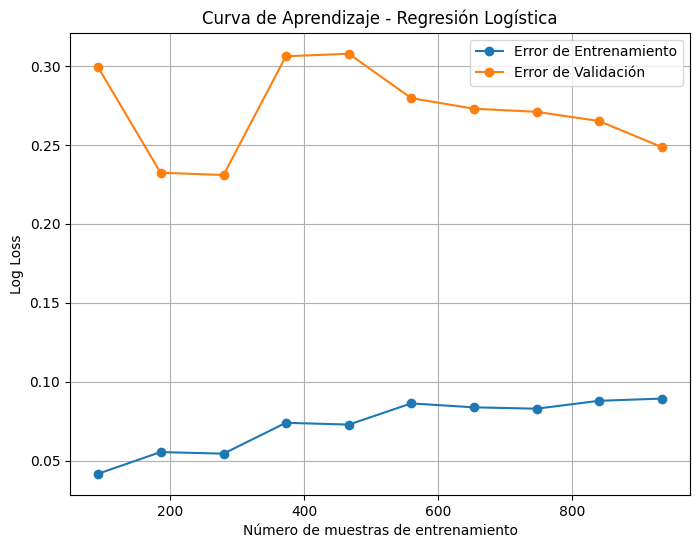

Tamaños de entrenamiento: [ 93 186 280 373 467 560 653 747 840 934]
Error de entrenamiento (Log Loss): [0.04168029 0.05539608 0.05440217 0.07395211 0.07281146 0.08624436
 0.08375613 0.08289312 0.08787042 0.08929187]
Error de validación (Log Loss): [0.29913456 0.23242137 0.23096216 0.30619171 0.30782139 0.27968411
 0.27301357 0.27099545 0.26519604 0.24865142]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import learning_curve
from pathlib import Path

X_train, X_test, y_train, y_test = joblib.load('data/splits.joblib')
model = joblib.load('models/logit_cara.joblib')

# Calcular la curva de aprendizaje
train_sizes, train_scores, valid_scores = learning_curve(
    model,
    X_train,
    y_train,
    cv=5,
    scoring='neg_log_loss',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1  # usar todos los núcleos disponibles
)

# Dado que se usa "neg_log_loss", convertimos a error (multiplicando por -1)
train_errors = -np.mean(train_scores, axis=1)
valid_errors = -np.mean(valid_scores, axis=1)

# Graficar las curvas de aprendizaje
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_errors, 'o-', label='Error de Entrenamiento')
plt.plot(train_sizes, valid_errors, 'o-', label='Error de Validación')
plt.xlabel('Número de muestras de entrenamiento')
plt.ylabel('Log Loss')
plt.title('Curva de Aprendizaje - Regresión Logística')
plt.legend()
plt.grid(True)

Path("figs").mkdir(parents=True, exist_ok=True)
plt.savefig('figs/learning_curve_logit.png', dpi=150)
plt.show()

# Imprimir los valores calculados
print("Tamaños de entrenamiento:", train_sizes)
print("Error de entrenamiento (Log Loss):", train_errors)
print("Error de validación (Log Loss):", valid_errors)


**Interpretación de Resultados:**  
1. **Sobreajuste (Overfitting):**  
   - El sobreajuste ocurre cuando el modelo memoriza demasiado los datos de entrenamiento, logrando un error muy bajo en `X_train`, pero fallando al generalizar en `X_test`.  
   - Un signo claro de sobreajuste es ver que el **Error de Entrenamiento** es significativamente menor que el **Error de Validación** y que ambas curvas no convergen a medida que aumenta el número de muestras de entrenamiento.

2. **Curvas de Aprendizaje (Learning Curves):**  
   - Se grafica la evolución del **Log Loss** (o la métrica que se haya elegido) en función del tamaño del set de entrenamiento. Suele mostrarse la curva de error de entrenamiento y la de validación.  
   - Si las curvas terminan en valores cercanos (p. ej. el error de entrenamiento ≈ error de validación), se concluye que **no hay sobreajuste** y que el modelo generaliza razonablemente bien.  
   - Si la curva de entrenamiento se mantiene muy por debajo de la curva de validación y existe una brecha notable, el modelo podría estar **sobreajustado**.  
   - Por el contrario, si ambas curvas se mantienen en valores altos y no convergen, se podría estar frente a **subajuste** (underfitting).

3. **Lectura de la Gráfica y de las Métricas:**  
   - En la gráfica, cada eje vertical (Log Loss en este caso) indica qué tan mala es la predicción en promedio: a menor valor, mejor el desempeño del modelo.  
   - El eje horizontal refleja el tamaño de la muestra de entrenamiento utilizada en cada punto.  
   - Un **patrón deseable** es aquel donde, al aumentar el número de muestras, el error de entrenamiento sube ligeramente (o se mantiene estable), mientras que el error de validación baja, y ambas curvas convergen o quedan muy cercanas.

4. **Conclusión sobre el Modelo:**  
   - Si las curvas de entrenamiento y validación convergen y el error de validación es razonablemente bajo, se concluye que el modelo **generaliza bien** y no hay indicios fuertes de sobreajuste.  
   - Si se observan divergencias claras o un error muy elevado en validación comparado con entrenamiento, se considera revisar la complejidad del modelo, la cantidad de variables o la necesidad de regularización.

Al final, el análisis de las curvas de aprendizaje complementa el uso de métricas puntuales (como accuracy o ROC AUC en el conjunto de prueba) al ofrecer una **perspectiva dinámica** de cómo el modelo aprende con diferentes cantidades de datos y si logra un equilibrio adecuado entre sesgo (bias) y varianza (variance).